## Library Imports

In [264]:
import os
import sys
import time
import argparse
import json



import cv2
import numpy as np
import torch.nn as nn
import torch.utils.data as data
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd


from herbie_vision.model.centernet import get_hourglass, exkp

from herbie_vision.model.utils.utils import _tranpose_and_gather_feature, load_model
from herbie_vision.model.utils.image import transform_preds, process_resizing
from herbie_vision.model.utils.losses import _neg_loss, _reg_loss
from herbie_vision.model.utils.summary import create_summary, create_logger, create_saver, DisablePrint
from herbie_vision.model.utils.post_process import ctdet_decode

from google.api_core.protobuf_helpers import get_messages
from google.cloud import storage

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/peterfagan/Desktop/gcp/waymo-2d-object-detection-514eeefdb0a3.json"

ImportError: cannot import name 'process_resizing' from 'herbie_vision.model.utils.image' (/Users/peterfagan/Code/Waymo-2D-Object-Detection/herbie_vision/model/utils/image.py)

## Data Import

In [10]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    
    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    )
    
    

client = storage.Client()
bucket = client.get_bucket('waymo-processed')

download_blob('waymo-processed',
              'train/images/2019-05-14/10231929575853664160_1160_000_1180_000/10231929575853664160_1160_000_1180_000_0_FRONT.jpeg',
              '/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/example_1.jpeg')
download_blob('waymo-processed',
              'train/annotations/2019-05-14/10231929575853664160_1160_000_1180_000.json',
              '/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/annotations.json')

Blob train/images/2019-05-14/10231929575853664160_1160_000_1180_000/10231929575853664160_1160_000_1180_000_0_FRONT.jpeg downloaded to /Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/example_1.jpeg.
Blob train/annotations/2019-05-14/10231929575853664160_1160_000_1180_000.json downloaded to /Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/annotations.json.


## Examine Annotations

In [11]:
# Read in image annotations
f = open('/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/annotations.json','r')
annotations = json.load(f)
f.close()

## Plot Bounding Boxes

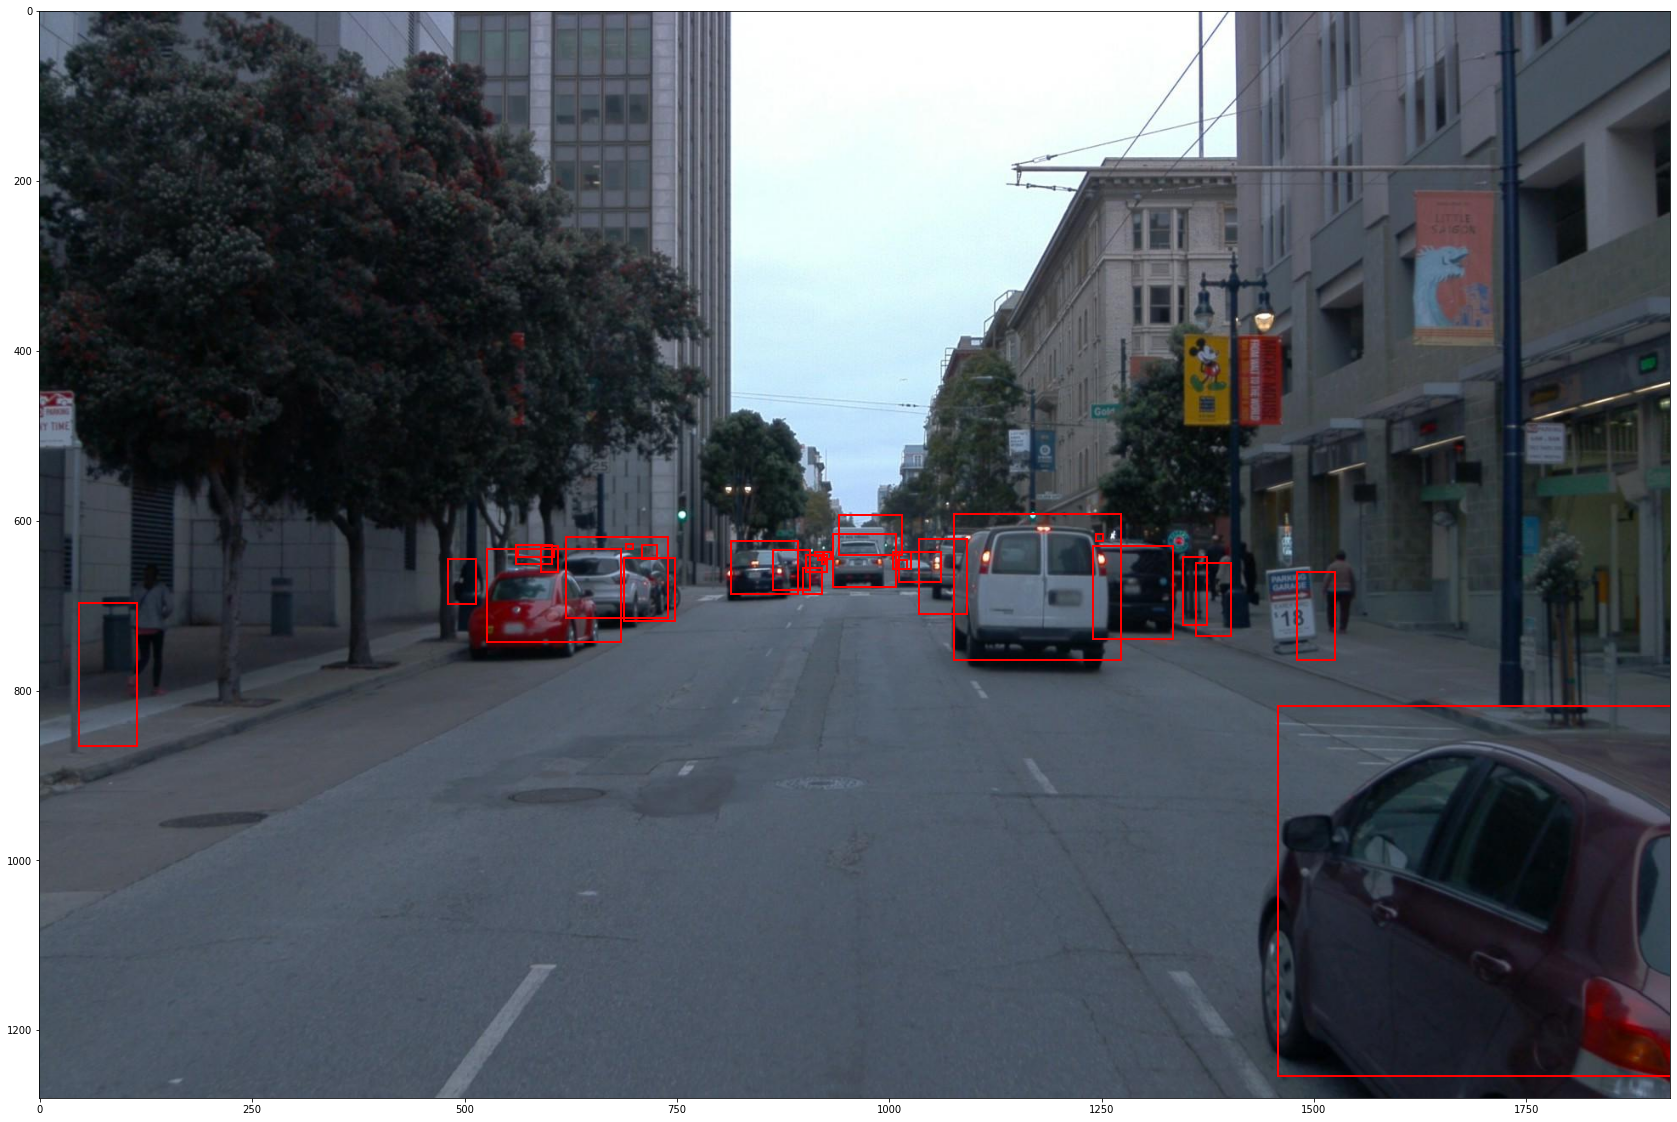

In [206]:
img = cv2.imread('/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/example_1.jpeg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
anns = [x for x in annotations['annotations'] if x['image_id']=='10231929575853664160_1160_000_1180_000_0_FRONT']

# Create figure and axes
fig, ax = plt.subplots(figsize = (200,20))

# Display the image
ax.imshow(rgb_img)

for entry in anns:
    h = entry['bbox'][3]
    w = entry['bbox'][2]
    x = entry['bbox'][0]
    y = entry['bbox'][1]
    
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y), h, w, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()


In [324]:
annotations_df = pd.DataFrame(annotations['annotations'])
annotations_df['filename'] = annotations_df['image_id'].apply(lambda x :os.getcwd()+'/data/images/{}.jpeg'.format(x))
annotations_df['x_min'] = annotations_df['bbox'].apply(lambda x: x[0])
annotations_df['y_min'] = annotations_df['bbox'].apply(lambda x: x[1])
annotations_df['width'] = annotations_df['bbox'].apply(lambda x: x[2])
annotations_df['height'] = annotations_df['bbox'].apply(lambda x: x[3])
annotations_df['x_max'] = annotations_df['x_min'] + annotations_df['width']
annotations_df['y_max'] = annotations_df['y_min'] + annotations_df['height']
annotations_df.drop(columns='bbox',inplace=True)
annotations_df = annotations_df[annotations_df['image_id']=='10241508783381919015_2889_360_2909_360_0_SIDE_RIGHT'].reset_index()

In [355]:
Y.shape

(886, 1920)

In [361]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)
    Y[bb[1]:bb[3], bb[0]:bb[2]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = np.array(Image.open(read_path))
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = write_path + read_path.split('/')[-1]
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)


def process_resizing(resized_path, annotations_df, sz):
    new_paths = []
    new_bbs = []
    for index, row in annotations_df[['filename','x_min','y_min','x_max','y_max']].iterrows():
        new_path,new_bb = resize_image_bb(row['filename'], resized_path,
                                          np.array(row[['x_min','y_min','x_max','y_max']]),sz)
        new_paths.append(new_path)
        new_bbs.append(new_bb)
    annotations_df['processed_filepath'] = new_paths
    annotations_df['new_bb'] = new_bbs
    
    return annotations_df

In [370]:
annotations_df = process_resizing('./data/processed_images/', annotations_df, 800)
annotations_df['xn_min'] = annotations_df['new_bb'].apply(lambda x: x[0])
annotations_df['yn_min'] = annotations_df['new_bb'].apply(lambda x: x[1])
annotations_df['xn_max'] = annotations_df['new_bb'].apply(lambda x: x[2])
annotations_df['yn_max'] = annotations_df['new_bb'].apply(lambda x: x[3])


In [382]:

Y = np.zeros((img.shape[0],img.shape[1]))
bb = bb.astype(int)
Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
plt.imshow(Y)



AttributeError: 'JpegImageFile' object has no attribute 'shape'

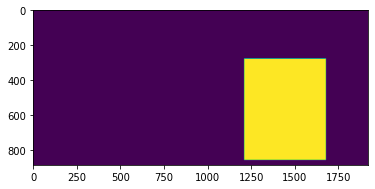

In [365]:
bb=np.array(annotations_df.iloc[6,:][['x_min','y_min','x_max','y_max']])
plt.imshow(create_mask(bb,img))

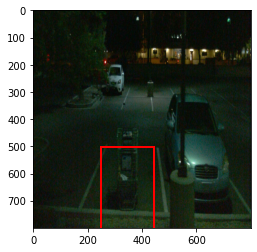

In [380]:
example = annotations_df.iloc[6,:]
img = Image.open(example['processed_filepath'])


# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

for entry in anns:
    h = example['yn_max'] - example['yn_min']
    w = example['xn_max'] - example['xn_min']
    x = example['xn_min']
    y = example['yn_min']
    
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y), h, w, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()


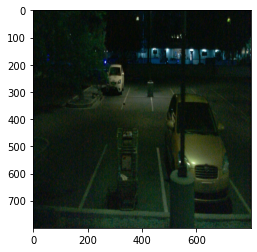

In [319]:
cv2.resize(img,(800,800))

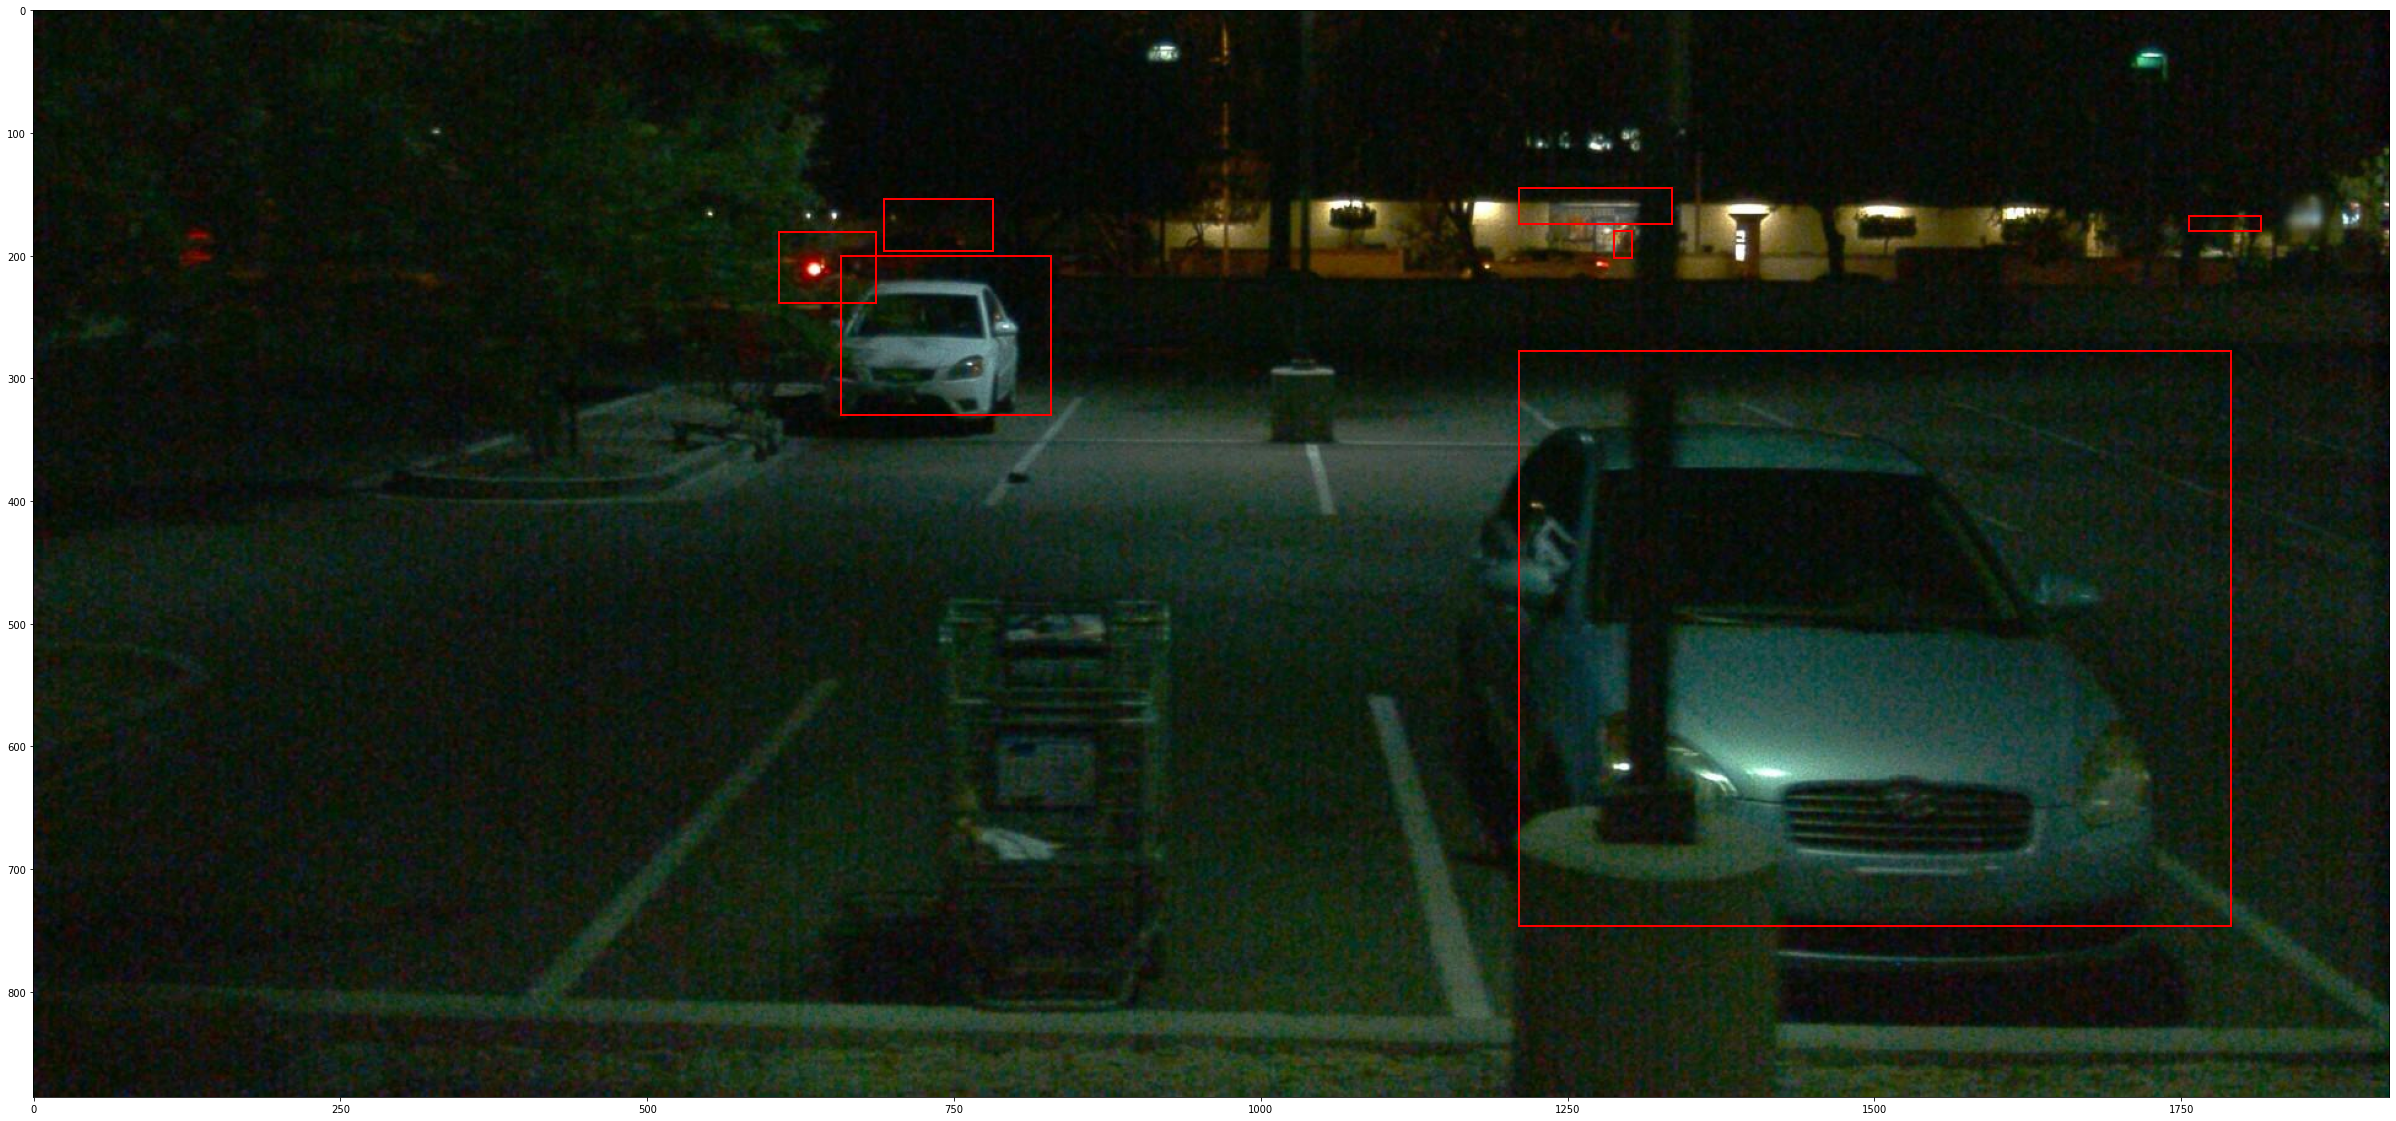

In [316]:
img = cv2.imread('/Users/peterfagan/Code/herbie-vision/herbie_vision/data/images/10241508783381919015_2889_360_2909_360_0_SIDE_RIGHT.jpeg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
anns = [x for x in annotations['annotations'] if x['image_id']=='10241508783381919015_2889_360_2909_360_0_SIDE_RIGHT']

# Create figure and axes
fig, ax = plt.subplots(figsize = (200,20))

# Display the image
ax.imshow(rgb_img)

for entry in anns:
    h = entry['bbox'][3]
    w = entry['bbox'][2]
    x = entry['bbox'][0]
    y = entry['bbox'][1]
    
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y), h, w, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

In [236]:
annotations_df = pd.DataFrame(annotations['annotations'])
annotations_df['filename'] = annotations_df['image_id'].apply(lambda x :os.getcwd()+'/data/images/{}.jpeg'.format(x))
annotations_df['x_min'] = annotations_df['bbox'].apply(lambda x: x[0])
annotations_df['y_min'] = annotations_df['bbox'].apply(lambda x: x[1])
annotations_df['width'] = annotations_df['bbox'].apply(lambda x: x[2])
annotations_df['height'] = annotations_df['bbox'].apply(lambda x: x[3])
annotations_df['x_max'] = annotations_df['x_min'] + annotations_df['width']
annotations_df['y_max'] = annotations_df['y_min'] + annotations_df['height']
annotations_df.drop(columns='bbox',inplace=True)

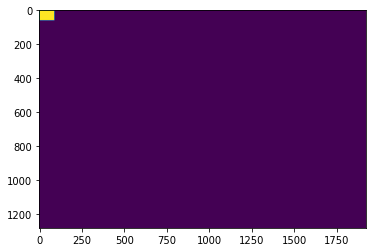

In [253]:
plt.imshow(create_mask(np.array([1,2,60,90]), rgb_img))

In [256]:
annotations_df

id  category_id  \
0     1c414850-561c-4c8e-9740-e5ea06ec124d            1   
1     314cb624-6c00-4a71-bf8c-ed483d296e53            1   
2     40d14545-2caa-4aba-8c04-2a965c8db25e            2   
3     41f8ffd6-e33e-4668-bf65-e8718390aa80            2   
4     5186ff87-939e-453a-bab3-637d0b169557            2   
...                                    ...          ...   
7036  77968084-3868-4b57-ac37-4ea3b5883405            1   
7037  d7902deb-6cdc-4aac-a65e-00d0ef1bfbf1            1   
7038  d9c8867f-5d0d-4f40-8402-feba30118232            2   
7039  e2e8256e-835a-4fdb-97b0-d4ac56505432            1   
7040  f41eed15-5a11-4db9-92e2-fe08fd84debd            1   

                                               image_id           area  \
0     10241508783381919015_2889_360_2909_360_0_FRONT...  121431.153026   
1     10241508783381919015_2889_360_2909_360_0_FRONT...   39289.771647   
2     10241508783381919015_2889_360_2909_360_0_FRONT...    1921.130950   
3     10241508783381919015_2889_360_2909_360_0_FRONT...     917.483635   
4     10241508783381919015_2889_360_2909_360_0_FRONT...    4146.627123   
...                                                 ...            ...   
7036  10241508783381919015_2889_360_2909_360_197_FRO...   67927.810949   
7037  10241508783381919015_2889_360_2909_360_197_FRO...   24526.059066   
7038  10241508783381919015_2889_360_2909_360_197_FRO...   22841.353443   
7039  10241508783381919015_2889_360_2909_360_197_FRO...   83355.335661   
7040  10241508783381919015_2889_360_2909_360_197_FRO...   23067.932010   

                                               filename        x_min  \
0     /Users/peterfagan/Code/herbie-vision/herbie_vi...   -33.316372   
1     /Users/peterfagan/Code/herbie-vision/herbie_vi...   259.374637   
2     /Users/peterfagan/Code/herbie-vision/herbie_vi...    65.053770   
3     /Users/peterfagan/Code/herbie-vision/herbie_vi...   126.318000   
4     /Users/peterfagan/Code/herbie-vision/herbie_vi...   957.174645   
...                                                 ...          ...   
7036  /Users/peterfagan/Code/herbie-vision/herbie_vi...  1403.778189   
7037  /Users/peterfagan/Code/herbie-vision/herbie_vi...  1138.544097   
7038  /Users/peterfagan/Code/herbie-vision/herbie_vi...  1736.556705   
7039  /Users/peterfagan/Code/herbie-vision/herbie_vi...  1627.274451   
7040  /Users/peterfagan/Code/herbie-vision/herbie_vi...  1042.439295   

           y_min       width      height        x_max        y_max  
0     761.223847  383.375130  316.742385   350.058757  1077.966232  
1     588.536833  140.212769  280.215360   399.587407   868.752192  
2     689.696280   54.316740   35.369040   119.370510   725.065320  
3     705.170235   58.106280   15.789750   184.424280   720.959985  
4     714.012495  104.212350   39.790170  1061.386995   753.802665  
...          ...         ...         ...          ...          ...  
7036  168.739767  211.021190  321.900426  1614.799379   490.640193  
7037  192.529652  107.370300  228.424984  1245.914397   420.954636  
7038  375.796050  258.320310   88.422600  1994.877015   464.218650  
7039  213.494092  244.425330  341.025767  1871.699781   554.519859  
7040  192.634950  115.580970  199.582440  1158.020265   392.217390  

[7041 rows x 11 columns]

In [263]:
annotations_df = process_resizing('./data/processed_images/', annotations_df,800)

In [271]:
annotations_df
annotations_df['xn_min'] = annotations_df['new_bb'].apply(lambda x: x[0])
annotations_df['yn_min'] = annotations_df['new_bb'].apply(lambda x: x[1])
annotations_df['xn_max'] = annotations_df['new_bb'].apply(lambda x: x[2])
annotations_df['yn_max'] = annotations_df['new_bb'].apply(lambda x: x[3])


In [307]:
annotations_df[annotations_df['image_id']=='10241508783381919015_2889_360_2909_360_0_SIDE_RIGHT']

id  category_id  \
33  07507d8c-1370-4da9-9e26-653a8db466dd            1   
34  15a7b27d-661e-4098-b2cf-5e72383d6f54            1   
35  35638d10-0cf8-4f72-a5d6-3dd10a8433e3            1   
36  55cdbaeb-371c-40d5-908c-5d9f71a1417e            1   
37  9d3bc65f-50a7-400b-8435-e0da42e93c98            2   
38  d99a2d82-1240-4f8f-a91f-8815183f1e1c            1   
39  f77ef744-9ad8-4ed3-8261-82d419f8b808            1   

                                             image_id           area  \
33  10241508783381919015_2889_360_2909_360_0_SIDE_...     741.965026   
34  10241508783381919015_2889_360_2909_360_0_SIDE_...    3712.218567   
35  10241508783381919015_2889_360_2909_360_0_SIDE_...    3741.737606   
36  10241508783381919015_2889_360_2909_360_0_SIDE_...    4537.554932   
37  10241508783381919015_2889_360_2909_360_0_SIDE_...     325.700290   
38  10241508783381919015_2889_360_2909_360_0_SIDE_...   22269.322342   
39  10241508783381919015_2889_360_2909_360_0_SIDE_...  271717.166361   

                                             filename        x_min  \
33  /Users/peterfagan/Code/herbie-vision/herbie_vi...  1756.451790   
34  /Users/peterfagan/Code/herbie-vision/herbie_vi...  1210.442235   
35  /Users/peterfagan/Code/herbie-vision/herbie_vi...   693.170025   
36  /Users/peterfagan/Code/herbie-vision/herbie_vi...   607.273785   
37  /Users/peterfagan/Code/herbie-vision/herbie_vi...  1287.652815   
38  /Users/peterfagan/Code/herbie-vision/herbie_vi...   658.116780   
39  /Users/peterfagan/Code/herbie-vision/herbie_vi...  1210.758030   

         y_min       width     height        x_max       y_max  \
33  167.687145   12.631800   58.73787  1769.083590  226.425015   
34  144.634110   29.684730  125.05482  1240.126965  269.688930   
35  154.107960   42.316530   88.42260   735.486555  242.530560   
36  180.950535   57.474690   78.94875   664.748475  259.899285   
37  179.687355   22.421004   14.52657  1310.073819  194.213925   
38  199.898235  130.107540  171.16089   788.224320  371.059125   
39  277.899600  468.639780  579.79962  1679.397810  857.699220   

                                   processed_filepath  \
33  ./data/processed_images/10241508783381919015_2...   
34  ./data/processed_images/10241508783381919015_2...   
35  ./data/processed_images/10241508783381919015_2...   
36  ./data/processed_images/10241508783381919015_2...   
37  ./data/processed_images/10241508783381919015_2...   
38  ./data/processed_images/10241508783381919015_2...   
39  ./data/processed_images/10241508783381919015_2...   

                         new_bb  xn_min  yn_min  xn_max  ym_max  yn_max  
33         [0.0, 0.0, 0.0, 0.0]     0.0     0.0     0.0     0.0     0.0  
34         [0.0, 0.0, 0.0, 0.0]     0.0     0.0     0.0     0.0     0.0  
35  [625.0, 64.0, 663.0, 100.0]   625.0    64.0   663.0   100.0   100.0  
36  [548.0, 75.0, 599.0, 107.0]   548.0    75.0   599.0   107.0   107.0  
37         [0.0, 0.0, 0.0, 0.0]     0.0     0.0     0.0     0.0     0.0  
38  [594.0, 83.0, 711.0, 154.0]   594.0    83.0   711.0   154.0   154.0  
39         [0.0, 0.0, 0.0, 0.0]     0.0     0.0     0.0     0.0     0.0

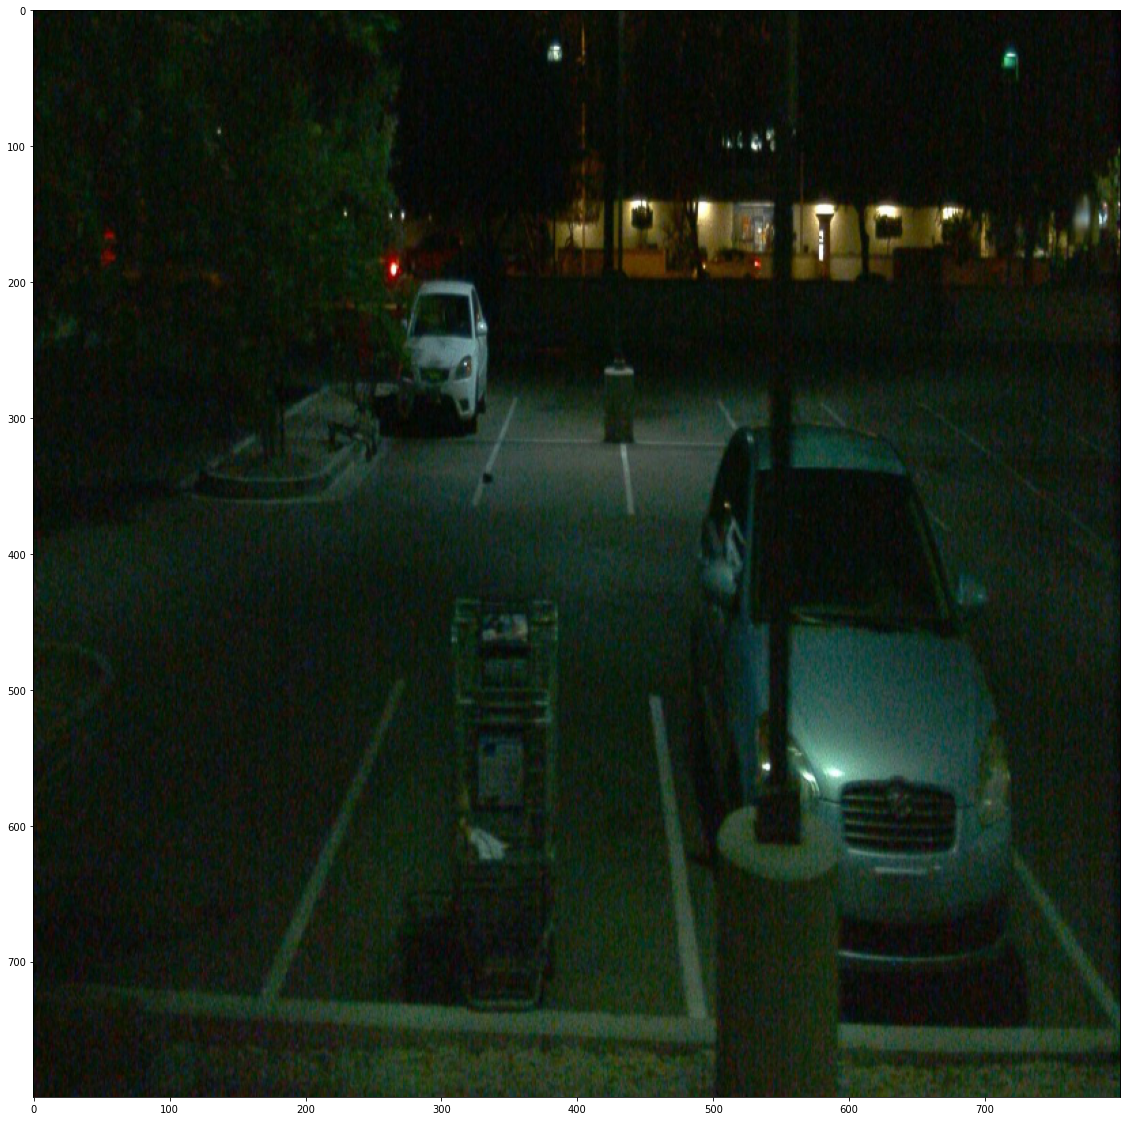

In [315]:
example = annotations_df.iloc[39,:]
img = Image.open(example['processed_filepath'])


# Create figure and axes
fig, ax = plt.subplots(figsize = (200,20))

# Display the image
ax.imshow(img)

for entry in anns:
    h = example['yn_max'] - example['yn_min']
    w = example['xn_max'] - example['xn_min']
    x = example['xn_min']
    y = example['yn_min']
    
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y), h, w, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()


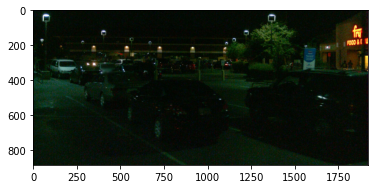

In [299]:
plt.imshow(img)

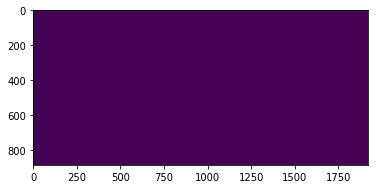

In [300]:
num=18
filename = annotations_df.iloc[num,:]['filename']
bb = np.array(annotations_df.iloc[num,:][['x_min','y_min','x_max','y_max']])

img = np.array(Image.open(filename))
msk=create_mask(bb,img)

plt.imshow(msk)

In [ ]:
mask = create_mask(bb, im)
cv2.resize(, (sz, sz))

## Model Playground

### Faster rcnn

In [183]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Initialize model and set to eval mode
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# test some dummy inputs
inputs = torch.randn(3,1200,1200).unsqueeze(0)
print(model(inputs))

# test real image inputs
inputs = torch.tensor(img).permute(2,0,1).unsqueeze(0).float()
print(model(inputs))

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward>)}]


### Centernet

In [186]:
# instantiate model
model = exkp(n=5, nstack=2, dims=[256, 256, 384, 384, 384, 512], modules=[2, 2, 2, 2, 2, 4],num_classes=3)
model.train()

    
inputs = torch.randn(1,3,512,512)
outputs = model(inputs)
hmap_tl, hmap_br, hmap_ct, embd_tl, embd_br, regs_tl, regs_br, regs_ct = zip(*outputs)

In [176]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    )
    

CATEGORY_NAMES = ['TYPE_VEHICLE','TYPE_PEDESTRIAN','TYPE_CYCLIST']
CATEGORY_IDS = [1,2,4]

class WaymoDataset(data.Dataset):
    def __init__(self, gcp_bucket, gcp_annotations_path, local_path_to_images, 
                 local_path_to_processed_images, cat_names, cat_ids):
        super(WaymoDataset, self).__init__()
        
        # filepaths
        self.gcp_bucket = gcp_bucket
        self.gcp_annotations_path = gcp_annotations_path
        self.local_path_to_images = local_path_to_images
        self.local_path_to_processed_images = local_path_to_processed_images
        
        # high level summary values
        self.num_classes = len(cat_names)
        self.category_names = cat_names
        self.category_ids = cat_ids
        
        
        # setup data directory
        if os.path.exists('./data')==False:
            os.mkdir('./data')
            os.mkdir(self.path_to_images)
            os.mkdir(self.path_to_processed_images)
        
        
        # read in annotations
        client = storage.Client()
        bucket = client.get_bucket(self.gcp_bucket)
        
        self.download_blob(self.gcp_bucket,
                           self.gcp_annotations_path,
                           './data/annotations.json')
        
        f = open('./data/annotations.json','r')
        self.annotations = json.load(f)
        f.close()
        
        # convert annotations to dataframe
        annotations_df = pd.DataFrame(annotations['annotations'])
        annotations_df['x'] = annotations_df['bbox'].apply(lambda x: x[0])
        annotations_df['y'] = annotations_df['bbox'].apply(lambda x: x[1])
        annotations_df['width'] = annotations_df['bbox'].apply(lambda x: x[2])
        annotations_df['height'] = annotations_df['bbox'].apply(lambda x: x[3])
        annotations_df.drop(columns='bbox')
        self.annotations_df = annotations_df

        
        # determine segment paths
        self.segment_paths = []
        for image in self.annotations['images']:
            uri = image['gcp_url']
            segment = '/'.join(uri.split('/')[3:7])+'/'
            if segment not in self.segment_paths:
                self.segment_paths.append(segment)
        
        
        # Download images for segments to local folder
#         for segment in self.segment_paths:
#             blobs = bucket.list_blobs(prefix=segment, delimiter='/')
#             for blob in list(blobs):
#                 filename=blob.name.replace(segment,'')
#                 blob.download_to_filename('./data/images/{}'.format(filename))


        # Preprocess images to be the same size
        self.annotations_df = process_resizing(self.path_to_processed_images, annotations_df,800)
        annotations_df['xn_min'] = annotations_df['new_bb'].apply(lambda x: x[0])
        annotations_df['yn_min'] = annotations_df['new_bb'].apply(lambda x: x[1])
        annotations_df['xn_max'] = annotations_df['new_bb'].apply(lambda x: x[2])
        annotations_df['ym_max'] = annotations_df['new_bb'].apply(lambda x: x[3])
        
            
    def __getitem__(self, idx):
        image_url = self.annotations['images'][idx]['gcp_url']
        filename = image_url.split('/')[-1]
        image = Image.open(self.path_to_processed_images+'{}'.format(filename))
        image = np.asarray(img, dtype="float64") / 255.
        image = torch.tensor(image).permute(2,0,1)        
        
        return image
        
    
    def __len__(self):
        return len(annotations['images'])

In [188]:
annotations['annotations']

[{'id': '093d54e1-3c23-4ba9-82df-7af5147ea494',
  'category_id': 1,
  'image_id': '10231929575853664160_1160_000_1180_000_0_FRONT',
  'area': 33512.087019680985,
  'bbox': [1076.545155, 592.4314200000001, 171.16089, 195.79289999999992]},
 {'id': '0bfc414a-1680-46c5-bafb-6db478aa9334',
  'category_id': 1,
  'image_id': '10231929575853664160_1160_000_1180_000_0_FRONT',
  'area': 4433.839390831497,
  'bbox': [687.485715, 644.537595, 73.89603, 60.001049999999964]},
 {'id': '1854be6b-ca54-4ce2-ad6c-4e024b31b15f',
  'category_id': 2,
  'image_id': '10231929575853664160_1160_000_1180_000_0_FRONT',
  'area': 4710.281199004811,
  'bbox': [1479.8153700000003,
   660.6431399999999,
   103.58076000000005,
   45.474480000000085]},
 {'id': '1ddec097-3e93-4d10-b565-19faf4e998b6',
  'category_id': 1,
  'image_id': '10231929575853664160_1160_000_1180_000_0_FRONT',
  'area': 17183.670664763707,
  'bbox': [526.430265, 633.168975, 109.26507000000004, 157.26591000000002]},
 {'id': '363ddee4-390d-4f1f-b466-

In [230]:
dataset = WaymoDataset('waymo-processed','train/annotations/2017-10-06/10241508783381919015_2889_360_2909_360.json','/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/annotations.json', CATEGORY_NAMES, CATEGORY_IDS)
dataloader = data.DataLoader(dataset, batch_size=8, shuffle=True)

Blob train/annotations/2017-10-06/10241508783381919015_2889_360_2909_360.json downloaded to ./data/annotations.json.


In [232]:
annotations = dataset.annotations

In [187]:
for image in dataloader:
    print(len(image))
    print(image[0].shape)
    break

8
torch.Size([3, 886, 1920])


In [ ]:
768×1152

In [43]:
for image_path in dataloader:
    print(image_path)
    break

['gs://waymo-processed/train/images/2019-05-14/10231929575853664160_1160_000_1180_000/10231929575853664160_1160_000_1180_000_142_FRONT_RIGHT.jpeg', 'gs://waymo-processed/train/images/2019-05-14/10231929575853664160_1160_000_1180_000/10231929575853664160_1160_000_1180_000_142_FRONT.jpeg', 'gs://waymo-processed/train/images/2019-05-14/10231929575853664160_1160_000_1180_000/10231929575853664160_1160_000_1180_000_177_FRONT_LEFT.jpeg', 'gs://waymo-processed/train/images/2019-05-14/10231929575853664160_1160_000_1180_000/10231929575853664160_1160_000_1180_000_100_SIDE_LEFT.jpeg', 'gs://waymo-processed/train/images/2019-05-14/10231929575853664160_1160_000_1180_000/10231929575853664160_1160_000_1180_000_34_SIDE_LEFT.jpeg', 'gs://waymo-processed/train/images/2019-05-14/10231929575853664160_1160_000_1180_000/10231929575853664160_1160_000_1180_000_150_SIDE_RIGHT.jpeg', 'gs://waymo-processed/train/images/2019-05-14/10231929575853664160_1160_000_1180_000/10231929575853664160_1160_000_1180_000_125_SI